<b>Source Data: Pengamatan Unsur Iklim (Jumlah Curah Hujan, Hari Hujan, dan Penyinaran Matahari) menurut Bulan di Kota Samarinda, Badan Pusat Statistik.</b><br>
<b>Retrived from</b> https://samarindakota.bps.go.id/id/statistics-table/2/MjEyIzI=/pengamatan-unsur-iklim-jumlah-curah-hujan-hari-hujan-dan-penyinaran-matahari-menurut-bulan-di-kota-samarinda.html

I did web scraping data from the official website of the Indonesian government's central statistics agency.

# Import Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly
import plotly.offline as py
import warnings
warnings.filterwarnings("ignore")

# Preprocess Data

In [6]:
# open csv file
df_raw = pd.read_csv('Samarinda_Curah_Hujan.csv')

In [7]:
df_raw

,Years,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Januari,156.9,253.3,-,200.7,-,306.8,-,164.0,148.2,...,344.8,158.8,160.8,215.9,215.9,247.0,369,106.0,144.4,132.8
1,Februari,128.2,157.9,-,38.9,-,220.4,-,196.2,161.5,...,193,99.3,138.6,97.7,97.7,91.8,148,109.1,152.8,61.5
2,Maret,284.4,417.3,-,225.4,-,260.3,-,278.9,157.2,...,197.8,317.6,88.1,154.1,154.1,135.5,274,273.1,232.1,90.1
3,April,190.9,135.7,-,336.3,-,339.7,-,309.1,163.7,...,343.7,369.2,343.3,180.2,180.2,176.5,256,274.9,303.3,77.1
4,Mei,130.0,244.9,-,199.4,-,112.3,-,186.4,222.6,...,213.5,224.6,309.3,296.3,296.3,224.7,117,181.0,176.6,272.6
5,Juni,180.6,79.8,-,98.6,-,213.4,-,41.2,320.1,...,259.2,202.0,421.8,197.0,197.0,172.6,141,159.2,229.8,323.9
6,Juli,76.4,44.5,-,271.0,-,278.5,-,157.3,258.7,...,162.7,162.7,160.9,136.9,136.9,148.0,212,309.1,71.8,125.9
7,Agustus,32.7,95.6,-,145.4,-,132.9,-,122.7,144.1,...,57.6,99.3,249.7,47.9,47.9,228.7,350,141.8,45.0,165.2
8,September,73.5,273.8,-,94.1,-,182.6,-,98.5,202.0,...,-,226.4,100.0,127.4,127.4,282.5,244,465.9,134.3,128.2
9,Oktober,140.1,220.9,-,339.6,-,181.4,-,232.3,235.9,...,73.2,174.5,152.0,151.9,151.9,170.0,265,283.8,110.7,324.7


## We will imputing missing years value with monthly average rainfall

In [9]:
# Melt and convert
df_melted = df_raw.melt(id_vars=['Years'], var_name='year', value_name='rainfall')

# Add month and convert year
month_mapping = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4, 'Mei': 5, 'Juni': 6,
    'Juli': 7, 'Agustus': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}
df_melted['month'] = df_melted['Years'].map(month_mapping)
df_melted['year'] = df_melted['year'].astype(int)

# Convert rainfall to numeric
df_melted['rainfall'] = pd.to_numeric(df_melted['rainfall'], errors='coerce')

# Mark missing rows BEFORE imputation
df_melted['was_missing'] = df_melted['rainfall'].isna()

# Impute using monthly average
df_melted['y'] = df_melted.groupby('month')['rainfall'].transform(lambda x: x.fillna(x.mean()))

# Create datetime
df_melted['ds'] = pd.to_datetime(dict(year=df_melted['year'], month=df_melted['month'], day=1))

# Filter imputed values only
df_imputed_only = df_melted[df_melted['was_missing'] == True][['ds', 'y']]
print("Rows with imputed rainfall values:")
df_imputed_only

Rows with imputed rainfall values:


,ds,y
24,2004-01-01,216.121053
25,2004-02-01,153.636842
26,2004-03-01,237.442105
27,2004-04-01,251.300000
28,2004-05-01,222.068421
29,2004-06-01,194.942105
30,2004-07-01,165.584211
31,2004-08-01,126.431579
32,2004-09-01,179.450000
33,2004-10-01,197.931579


Rainfall is seasonal — each month tends to have a consistent pattern across years. We do imputing by monthly average preserves seasonal trends and avoids unrealistic values from unrelated months.

In [11]:
# Final dataset with all values — imputed and original
df = df_melted[['ds', 'y']].copy()
df

,ds,y
0,2002-01-01,156.9
1,2002-02-01,128.2
2,2002-03-01,284.4
3,2002-04-01,190.9
4,2002-05-01,130.0
...,...,...
271,2024-08-01,165.2
272,2024-09-01,128.2
273,2024-10-01,324.7
274,2024-11-01,136.9


## Checking sample 2004
Just make sure the data is correct

In [13]:
df_2004 = df[df['ds'].dt.year == 2004]
df_2004

,ds,y
24,2004-01-01,216.121053
25,2004-02-01,153.636842
26,2004-03-01,237.442105
27,2004-04-01,251.300000
28,2004-05-01,222.068421
29,2004-06-01,194.942105
30,2004-07-01,165.584211
31,2004-08-01,126.431579
32,2004-09-01,179.450000
33,2004-10-01,197.931579


all seems correct

In [15]:
df.isnull().sum() #checking for missing values

ds    0
y     0
dtype: int64

# Exploratory Data Analysis

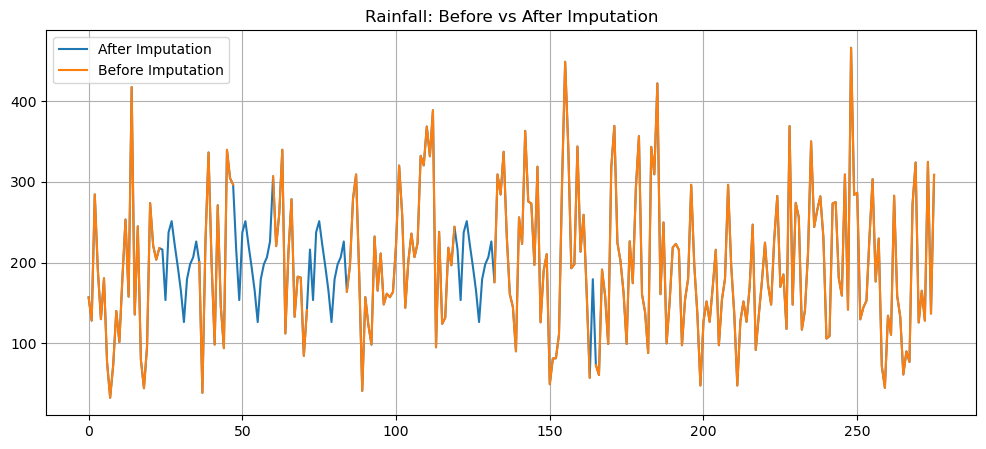

In [17]:
plt.figure(figsize=(12, 5))
df['y'].plot(label='After Imputation')
df_melted['rainfall'].plot(label='Before Imputation')
plt.title('Rainfall: Before vs After Imputation')
plt.legend()
plt.grid(True)
plt.show()

The imputed series appears smoother and more stable, especially during previously sparse regions. This helps improve model reliability but may also suppress some natural variability, so interpretation should balance data integrity with model consistency.

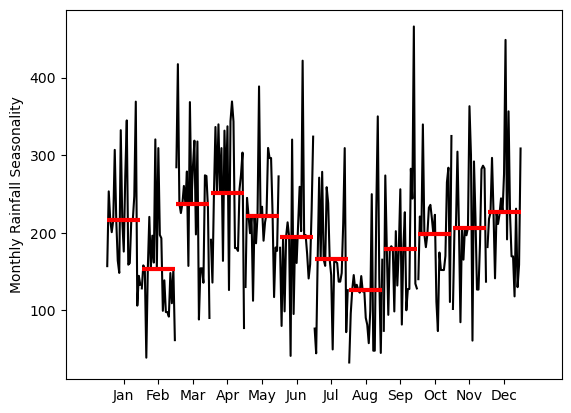

In [18]:
df = df.set_index('ds')
month_plot(df['y'].resample('ME').mean(), ylabel= 'Monthly Rainfall Seasonality')
plt.show()

Rainfall in Samarinda exhibits clear seasonal behavior. Months like March-May, and October–December show higher average rainfall, while August-September are typically drier. 

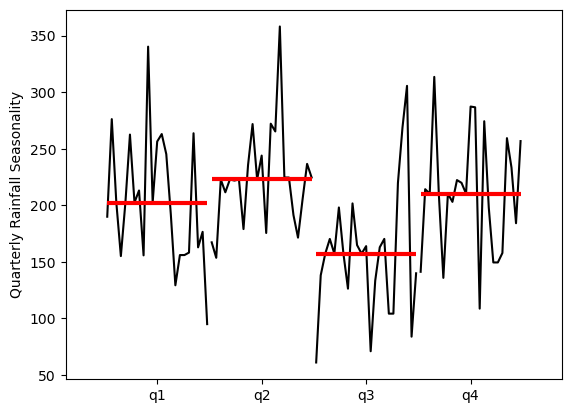

In [19]:
quarter_plot(df['y'].resample('QE').mean(), ylabel = 'Quarterly Rainfall Seasonality')
plt.show()

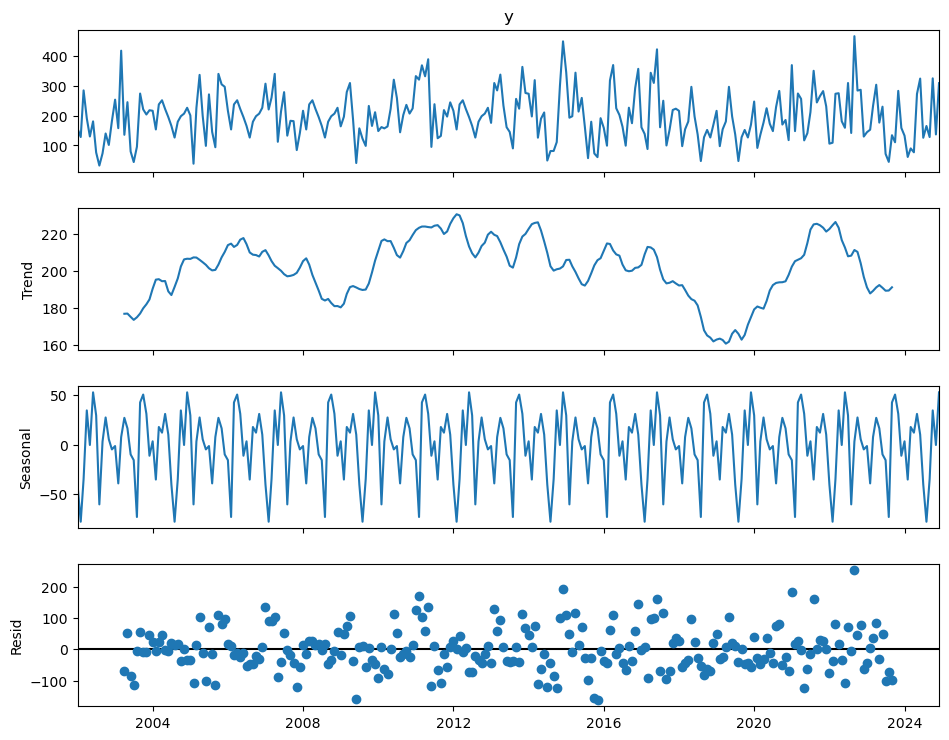

In [20]:
decomposition = seasonal_decompose(df['y'],
                                   model = 'add',
                                   period =30)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

The decomposition confirms that Samarinda’s rainfall is driven by a clear seasonal cycle and evolving long-term trend, while also exhibiting non-negligible irregularities — likely due to extreme weather events. These residual spikes are strong candidates for outlier analysis and anomaly detection in climate modeling.

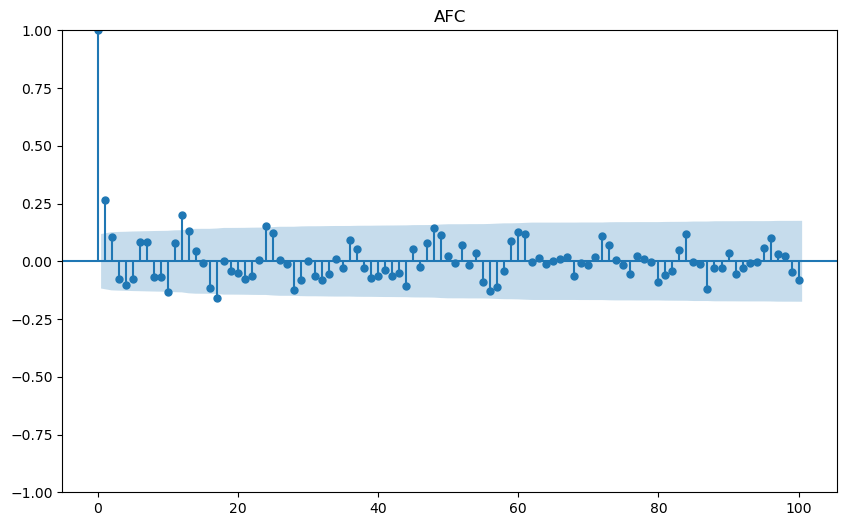

In [21]:
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.title('AFC')
plt.show()

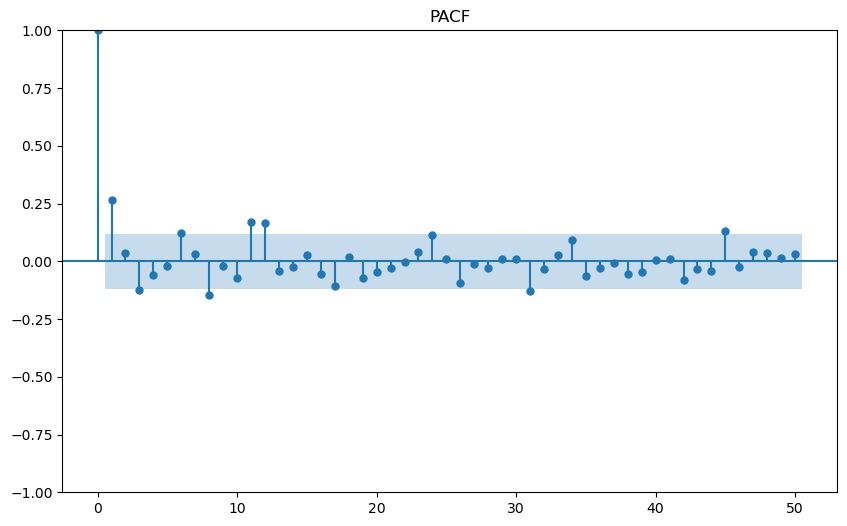

In [22]:
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 50, ax = ax)
plt.title('PACF')
plt.show()

# Train Test Split

In [24]:
df = df.reset_index()  # Prophet doesnt need ds or datetime to be index, but it need separate dataframe for holiday.
size = int(len(df)*0.80) #80/20 split
df_train, df_test = df.iloc[:size], df.iloc[size:]

# Parameter Tuning

In [26]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],           # Smaller → smoother trend
    'seasonality_prior_scale': [5, 10, 20, 30],                 # How much seasonal flexibility        
    'seasonality_mode':['additive', 'multiplicative'],     # Better for rainfall
}

all_params = list(ParameterGrid(param_grid))
all_params

[{'changepoint_prior_scale': 0.01,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.01,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 30},
 {'changepoint_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 30},
 {'changepoint_prior_scale': 0.05,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.05,
  'seasonality_mo

In [28]:
tuning_results = []

for params in all_params:
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        seasonality_mode=params.get('seasonality_mode', 'multiplicative'),
        changepoint_prior_scale=params.get('changepoint_prior_scale'),
        seasonality_prior_scale=params.get('seasonality_prior_scale'),
    )
    m.fit(df_train)

    df_cv = cross_validation(
        model=m,
        initial='3600 days',
        period='30 days',
        horizon='30 days',
        parallel='processes'
    )

    rmse = round(performance_metrics(df_cv)['rmse'].mean(), 2)
    tuning_results.append(rmse)

# Rank results
outcome = pd.DataFrame(all_params)
outcome['rmse'] = tuning_results
outcome = outcome.sort_values('rmse')

17:24:57 - cmdstanpy - INFO - Chain [1] start processing
17:24:57 - cmdstanpy - INFO - Chain [1] done processing
17:25:03 - cmdstanpy - INFO - Chain [1] start processing
17:25:04 - cmdstanpy - INFO - Chain [1] done processing
17:25:11 - cmdstanpy - INFO - Chain [1] start processing
17:25:12 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:26 - cmdstanpy - INFO - Chain [1] start processing
17:25:26 - cmdstanpy - INFO - Chain [1] done processing
17:25:35 - cmdstanpy - INFO - Chain [1] start processing
17:25:35 - cmdstanpy - INFO - Chain [1] done processing
17:25:44 - cmdstanpy - INFO - Chain [1] start processing
17:25:44 - cmdstanpy - INFO - Chain [1] done processing
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
17:26:02 - cmdstanpy - INFO - Chain [1] start processing
17:26:02 - cmdstanpy - INFO - Chain [1]

In [29]:
outcome

,changepoint_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
4,0.01,multiplicative,5,77.43
1,0.01,additive,10,77.75
5,0.01,multiplicative,10,78.05
21,0.10,multiplicative,10,78.08
23,0.10,multiplicative,30,78.11
22,0.10,multiplicative,20,78.14
3,0.01,additive,30,78.19
2,0.01,additive,20,78.24
7,0.01,multiplicative,30,78.31
16,0.10,additive,5,78.37


In [30]:
best_params = all_params[tuning_results.index(min(tuning_results))] #find the lowest
best_params

{'changepoint_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 5}

# Prophet Model

In [50]:
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        seasonality_mode='multiplicative',
        seasonality_prior_scale=5,
        changepoint_prior_scale=0.01
    )
m.fit(df_train)

17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing


# Cross-Validation

In [53]:
df_cv = cross_validation(
    model=m, 
    initial='3600 days',    # ~10 years of training
    period='30 days',      # move forward 30 days
    horizon='30 days',     # predict 30 days ahead
    parallel='processes'
)

performance_metrics(df_cv)
mape = round(performance_metrics(df_cv)['mape'].mean() * 100,2)
rmse = round(performance_metrics(df_cv)['rmse'].mean(),0)
print(f'The Mape is {mape} %') 
print(f'The Rmse is {rmse}') 

The Mape is 46.55 %
The Rmse is 77.0


These indicate moderate forecast accuracy. A MAPE of 46.55% means the predictions, on average, are off by nearly half of the true value — which is expected for highly variable data like rainfall.

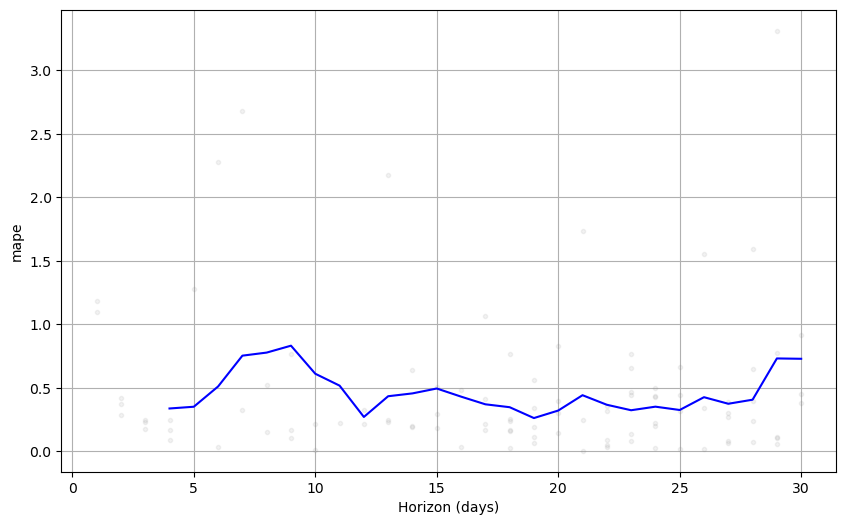

In [54]:
plot_cross_validation_metric(df_cv, metric = 'mape');

The Prophet model performs more reliably around the 15–25 day forecast range but still struggles with precision due to the high volatility and outliers in the rainfall series. The high MAPE reinforces the importance of modeling anomalies or supplementing the model with additional features (e.g., weather patterns or climate indicators).

# Forecasting

In [58]:
future = m.make_future_dataframe(periods = 56, freq='MS') 
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
271,2024-08-01,208.138058,45.855425,207.247905,208.138052,208.138065,-0.396149,-0.396149,-0.396149,-0.396149,-0.396149,-0.396149,0.0,0.0,0.0,125.684447
272,2024-09-01,208.207329,94.933092,257.417000,208.207322,208.207336,-0.143465,-0.143465,-0.143465,-0.143465,-0.143465,-0.143465,0.0,0.0,0.0,178.336866
273,2024-10-01,208.274365,127.526898,289.470254,208.274358,208.274372,-0.000451,-0.000451,-0.000451,-0.000451,-0.000451,-0.000451,0.0,0.0,0.0,208.180496
274,2024-11-01,208.343635,136.259583,299.583706,208.343629,208.343643,0.030256,0.030256,0.030256,0.030256,0.030256,0.030256,0.0,0.0,0.0,214.647225
275,2024-12-01,208.410672,170.155411,335.820272,208.410664,208.410679,0.196654,0.196654,0.196654,0.196654,0.196654,0.196654,0.0,0.0,0.0,249.395366


# Data visualization

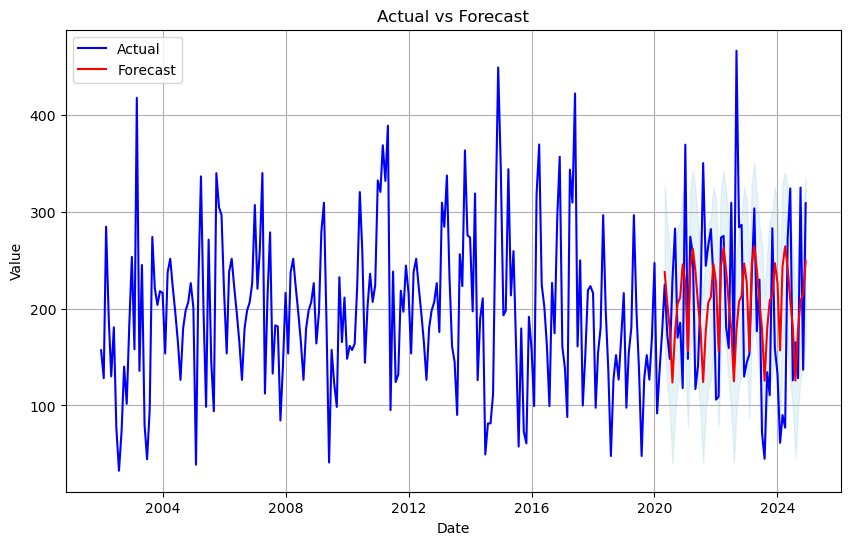

In [77]:
# Filter the forecast only for the test period
forecast_test = forecast[forecast['ds'].isin(df_test['ds'])]

# Plot
plt.figure(figsize=(10, 6))

# Actual full data
plt.plot(df['ds'], df['y'], label='Actual', color='blue')

# Forecasted values only for test period
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='red')

# Confidence interval
plt.fill_between(forecast_test['ds'],
                 forecast_test['yhat_lower'],
                 forecast_test['yhat_upper'],
                 color='lightblue', alpha=0.3)

# Labels
plt.title("Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

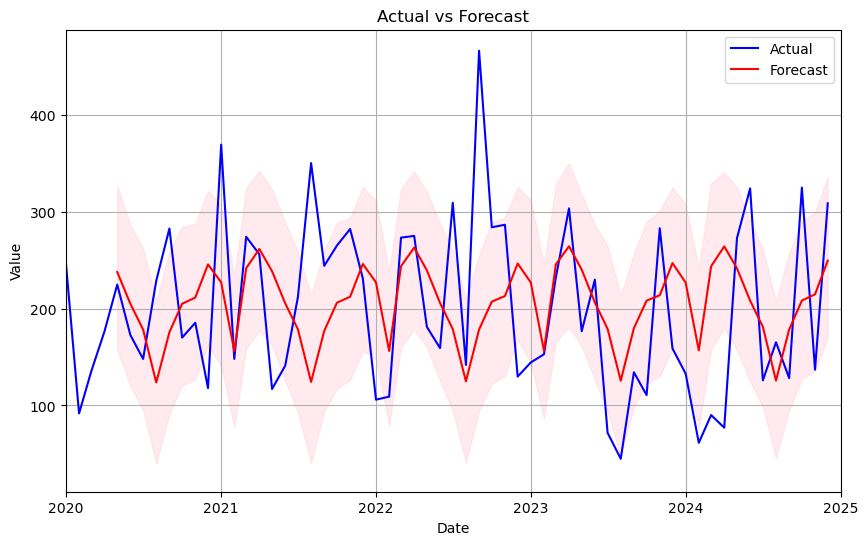

In [83]:
plt.figure(figsize=(10, 6))

# Actual full data
plt.plot(df['ds'], df['y'], label='Actual', color='blue')

# Forecasted values only for test period
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='red')

# Confidence interval
plt.fill_between(forecast_test['ds'],
                 forecast_test['yhat_lower'],
                 forecast_test['yhat_upper'],
                 color='pink', alpha=0.3)

# Labels
plt.title("Actual vs Forecast")
plt.xlim(pd.to_datetime('2020'), pd.to_datetime('2025'))
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

While the Prophet model is effective in modeling central trends and repeating seasonal patterns, it falls short in capturing the increasing irregularity and magnitude of rainfall outliers in recent years. This underscores the need for alternative models or exogenous variables to improve forecasting under extreme climate variability.

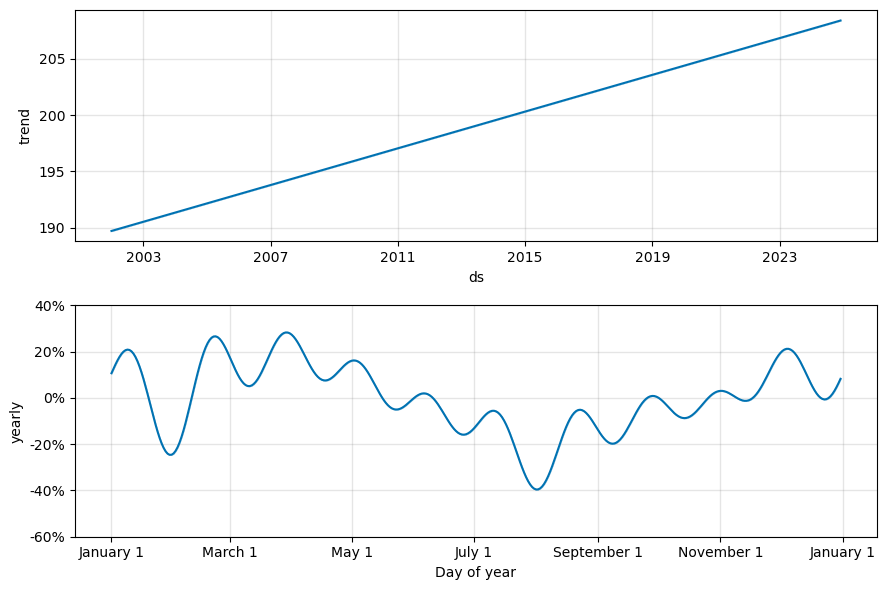

In [85]:
m.plot_components(forecast)
plt.show()

The Prophet model identifies a consistent annual cycle in Samarinda’s rainfall and a long-term upward trend in total volume. This supports the idea that not only does rainfall follow seasonal behavior, but the overall intensity of rainfall may be increasing over time. It also seems that the outlier and residual happen to support this.

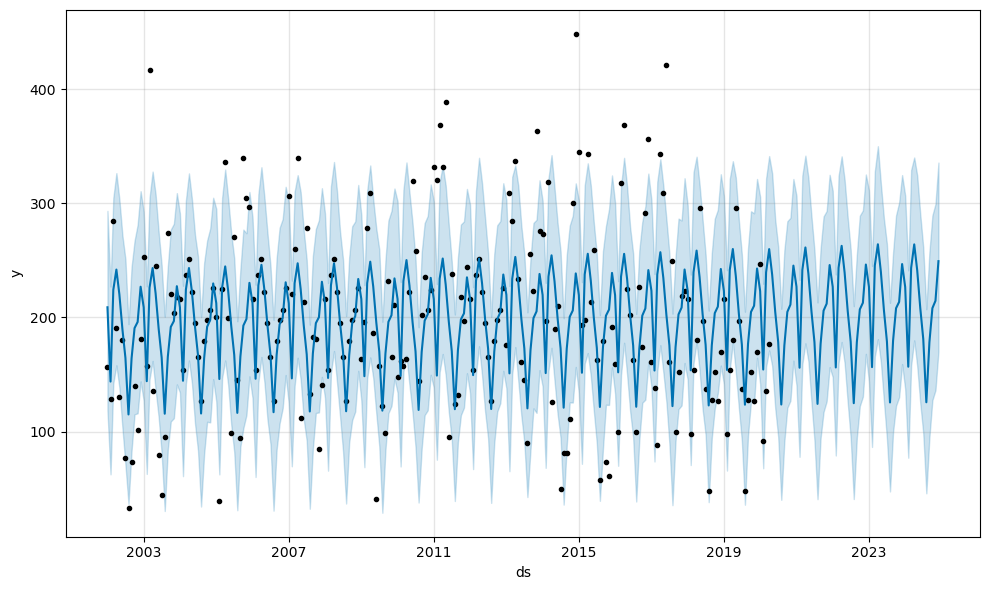

In [111]:
m.plot(forecast)
plt.show()

Prophet effectively models seasonality and trend, but frequent deviation of actual values from the forecast bounds—particularly in the form of high spikes—suggests the presence of growing anomalies and extreme weather events. These are not well captured by Prophet’s default assumptions, reinforcing the need for outlier detection and hybrid or anomaly-aware models.

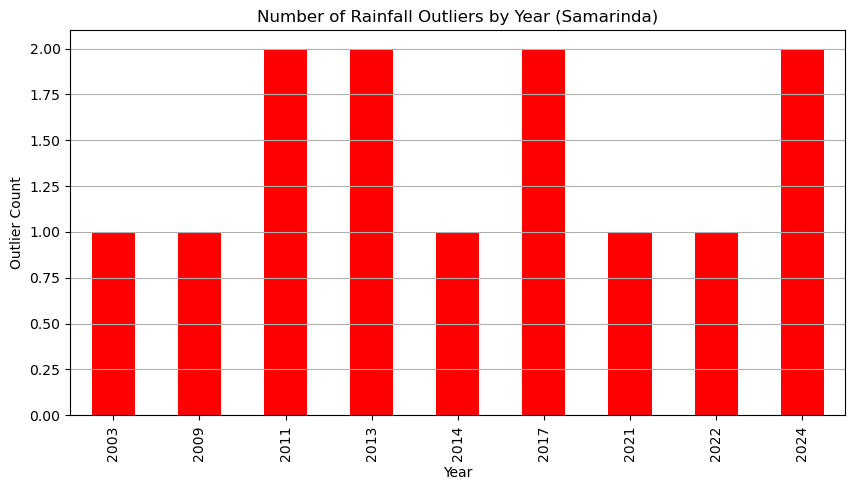

In [95]:
# Merge actual values from full df (real values) with predictions
df_compare = df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# Calculate residuals
df_compare['residual'] = df_compare['y'] - df_compare['yhat']
# Use standard deviation threshold (e.g., ±2σ)
resid_std = df_compare['residual'].std()
df_compare['is_outlier'] = df_compare['residual'].abs() > 2 * resid_std
df_compare['year'] = df_compare['ds'].dt.year
outlier_count = df_compare[df_compare['is_outlier']].groupby('year').size()

plt.figure(figsize=(10, 5))
outlier_count.plot(kind='bar', color='red')
plt.title("Number of Rainfall Outliers by Year (Samarinda)")
plt.xlabel("Year")
plt.ylabel("Outlier Count")
plt.grid(axis='y')
plt.show()


The frequency of rainfall outliers in Samarinda appears to have increased in the last decade. This pattern may reflect changing climate dynamics, greater rainfall variability, or more frequent extreme weather events

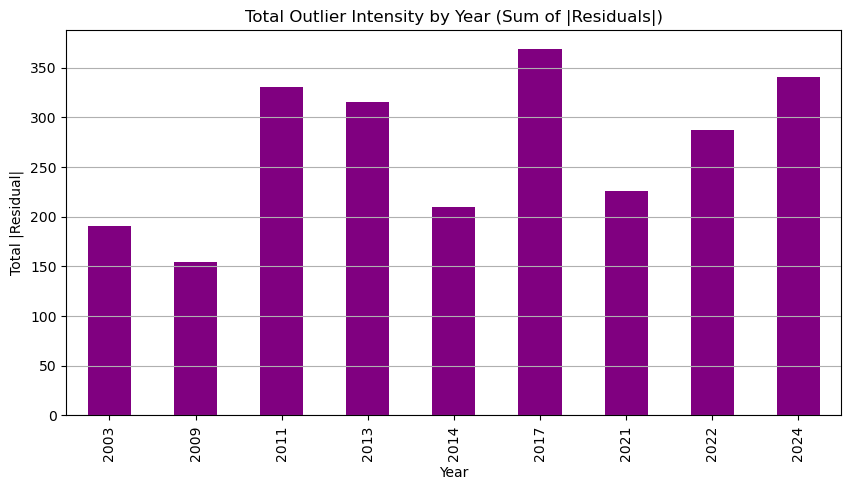

In [93]:
outlier_magnitude = df_compare[df_compare['is_outlier']].groupby('year')['residual'].apply(lambda x: x.abs().sum())

plt.figure(figsize=(10, 5))
outlier_magnitude.plot(kind='bar', color='purple')
plt.title("Total Outlier Intensity by Year (Sum of |Residuals|)")
plt.xlabel("Year")
plt.ylabel("Total |Residual|")
plt.grid(axis='y')
plt.show()


Although Prophet generally captured the seasonal and trend components of Samarinda's rainfall, residual analysis reveals a growing anomaly pattern. From 2011 onward, both the frequency and magnitude of rainfall outliers increased, with 2017 and 2024 standing out as years of extreme deviations. This may reflect a real-world shift in local climate behavior — such as increasing rainfall volatility or more intense weather events — that simple seasonality-based models struggle to capture.

# Conclution
While the number of outlier events fluctuates, the magnitude of those deviations has generally increased in recent years. This supports the idea that not only are extreme rainfall events more common, but they’re also becoming more severe.

However, further investigation is needed to evaluate the impact of land use changes — including deforestation and urban development — in Samarinda, as these factors directly affect the land’s water absorption capacity. A reduction in vegetation and permeable surfaces can lead to greater surface runoff, amplifying the impact of rainfall, even if actual precipitation or weather patterns have not significantly changed.

Beyond the increasing rainfall anomalies themselves, one of the main reasons Samarinda experiences severe flooding is the combination of rising rainfall volume and land use change. Deforestation and urbanization not only amplify the consequences of the same amount of rain, but also worsen the situation, as the rainfall volume itself has increased over time.